In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, Dataset
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import pyvene as pv
from tqdm.notebook import tqdm
import random
from collections import namedtuple
from copy import deepcopy

In [2]:
%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    theme,
    element_text,
    ggtitle, xlab, ylab
)
from plotnine.scales import scale_y_discrete, scale_fill_cmap

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data preparation

In [19]:
rooms_ds = load_dataset("tasksource/babi_nli", name='compound-coreference')
colors_ds = load_dataset("tasksource/babi_nli", name='basic-induction')

In [5]:
rooms_ds['train'].to_pandas().head(1)

,premise,hypothesis,label,idx
0,John and Daniel went to the office. After that...,John is in the kitchen.,1,0


In [6]:
colors_ds['train'].to_pandas().head(1)

,premise,hypothesis,label,idx
0,Lily is a rhino. Lily is white. Bernhard is a ...,Greg is yellow.,1,0


In [5]:
def prepare_last_as_label(data):
    data = deepcopy(data)
    for split in ['train', 'validation', 'test']:
        examples = data[split].filter(lambda x: x['label'] == 0)
        inputs = [ex['premise'] + " " + ex['hypothesis'].rsplit(" ", 1)[0] for ex in examples]
        labels = [ex['hypothesis'].rsplit(" ", 1)[-1].strip('.') for ex in examples]
        data[split] = Dataset.from_dict({'input': inputs, 'label': labels})
    return data

In [20]:
rooms = prepare_last_as_label(rooms_ds)
colors = prepare_last_as_label(colors_ds)

In [21]:
rooms['train'][0]

{'input': 'Daniel and Sandra went to the office. Following that they travelled to the hallway. Sandra is in the',
 'label': 'office'}

In [10]:
colors['train'][0]

{'input': 'Bernhard is a swan. Bernhard is green. Julius is a lion. Brian is a swan. Lily is a frog. Lily is yellow. Brian is gray. Julius is gray. Greg is a lion. Greg is',
 'label': 'green'}

### Prepare model

In [7]:
model_name = "gpt2-xl"
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    revision="main",
    return_dict_in_generate=True,
    torch_dtype=torch.float32
).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [8]:
def probing_config(intervention_site, layer, max_units):
    """Generate intervention config for probing."""
    config = pv.IntervenableConfig([{
        "layer": layer,
        "component": intervention_site,
        "max_number_of_units": max_units,
        "intervention_type": pv.CollectIntervention,
    }])
    return config

In [9]:
def get_label_mapping(labels):
    label_mapping = {label: i for i, label in enumerate(set(labels))}
    return label_mapping

In [14]:
room_label_mapping = get_label_mapping(rooms['train']['label'])
room_label_mapping.keys()

dict_keys(['bathroom', 'office', 'garden', 'hallway', 'bedroom', 'kitchen'])

In [10]:
color_label_mapping = get_label_mapping(colors['train']['label'])
color_label_mapping.keys()

dict_keys(['white', 'gray', 'green', 'yellow'])

In [11]:
def get_relevant_positions(text, tokenizer, labels, context_markers):
    tokens = tokenizer.tokenize(text)
    tokens = [token.replace('Ġ', '') for token in tokens]
    positions = {
        'last': set(),
        'label': set(),
        'name': set(),
        'context': set()
    }
    
    # Add final position (before room prediction)
    positions['last'].add(len(tokens) - 1)
    
    # Find positions of label words
    for i, token in enumerate(tokens):
        # Clean token for comparison
        clean_token = token.replace('Ġ', '').lower()
        if clean_token in labels:
            positions['label'].add(i)
            
    # Find positions of target name words
    target_name = text.split('. ')[-1].split(' ')[0] # Sarah, John, etc.
    target_name_tokens = [token.replace('Ġ', '') for token in tokenizer.tokenize(' '+target_name)]
    for i in range(len(tokens) - len(target_name_tokens) + 1):
        if tokens[i:i+len(target_name_tokens)] == target_name_tokens:
            positions['name'].add(i + len(target_name_tokens) - 1)
    
    # Find positions of key context phrases
    text_lower = text.lower()
    for marker in context_markers:
        if marker in text_lower:
            # Find position of marker in tokenized sequence
            marker_tokens = [token.replace('Ġ', '') for token in tokenizer.tokenize(' '+marker)]
            for i in range(len(tokens) - len(marker_tokens) + 1):
                if tokens[i:i+len(marker_tokens)] == marker_tokens:
                    positions['context'].add(i + len(marker_tokens) - 1)
    
    return positions

In [12]:
Example = namedtuple("Example", ["base", "src", "base_label", "src_label", "positions"])

def sample_example(sample, tokenizer, labels, context_markers):
    # get labels
    base_label = sample['label']
    src_label = random.choice([label for label in labels if label != base_label])
    
    # get texts
    base = sample['input']
    src = base.replace(base_label, src_label)
    
    # make pairs
    base = tokenizer(base, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    src = tokenizer(src, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    
    base_label = tokenizer.encode(" " + base_label)[0]
    src_label = tokenizer.encode(" " + src_label)[0]
    
    # get relevant positions
    positions = get_relevant_positions(sample['input'], tokenizer, labels, context_markers)
    
    return Example(base, src, base_label, src_label, positions)

def generate_doable_examples(data, model, tokenizer, labels, context_markers):
    examples = []
    for sample in tqdm(data):
        ex = sample_example(sample, tokenizer, labels, context_markers)
        for k, v in ex.base.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.base[k] = v.to(model.device)
        for k, v in ex.src.items():
            if v is not None and isinstance(v, torch.Tensor):
                ex.src[k] = v.to(model.device)

        # Get model predictions
        logits_base = model(**ex.base).logits[0, -1]
        logits_src = model(**ex.src).logits[0, -1]
        
        # examples.append(ex)
        
        # Check if model correctly predicts both labels
        if (
            logits_base[ex.base_label] > logits_base[ex.src_label]
            and logits_src[ex.src_label] > logits_src[ex.base_label]
        ):
            examples.append(ex)

    return examples

### Train probe

In [13]:
def train_eval_probe(model, tokenizer, trainset, evalset, label_mapping):
    # intervention settings
    stats = []
    num_layers = model.config.num_hidden_layers
    
    label_map = {tokenizer.encode(" " + k)[0]: v for k,v in label_mapping.items()}

    # loop over layers and positions
    with torch.no_grad():
        for layer in tqdm(range(num_layers)):
            for position in ['last', 'label', 'name', 'context']:
                # try:
                print(f"layer: {layer}, position: {position}")

                # set up intervenable model
                config = probing_config("block_output", layer, max_units=32)
                intervenable = pv.IntervenableModel(config, model)
                intervenable.set_device(device)
                intervenable.disable_model_gradients()

                # training loop
                activations, labels = [], []
                for example in trainset:
                    # relevant positions
                    pos_idx = list(example.positions[position])
                    
                    # forward pass
                    base_outputs, _ = intervenable(
                        example.base,
                        unit_locations={"base": pos_idx},
                    )
                    base_activations = base_outputs[1][0]

                    src_outputs, _ = intervenable(
                        example.src,
                        unit_locations={"base": pos_idx},
                    )
                    src_activations = src_outputs[1][0]
                    
                    # collect activation
                    activations.extend(
                        [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                    )
                    labels.extend([example.base_label, example.src_label])
                labels = [label_map[label] for label in labels]
                # except:
                #     return base_activations
                
                # train logistic regression
                lr = LogisticRegression(random_state=42, max_iter=1000).fit(
                    activations, labels
                )

                # eval
                activations, labels = [], []
                for example in tqdm(evalset):
                    # relevant positions
                    pos_idx = list(example.positions[position])
                    
                    # forward pass
                    base_outputs, _ = intervenable(
                        example.base,
                        unit_locations={"base": pos_idx},
                    )
                    base_activations = base_outputs[1][0]

                    src_outputs, _ = intervenable(
                        example.src,
                        unit_locations={"base": pos_idx},
                    )
                    src_activations = src_outputs[1][0]
                    
                    # collect activation
                    activations.extend(
                        [base_activations.detach()[0].cpu().numpy(), src_activations.detach()[0].cpu().numpy()]
                    )
                    labels.extend([example.base_label, example.src_label])
                labels = [label_map[label] for label in labels]

                # stats
                acc = lr.score(activations, labels)
                f1 = f1_score(labels, lr.predict(activations), average="macro")
                stats.append({"layer": layer, "position": position, "acc": acc, "f1": f1})
                print(f"acc: {acc:.3%}, f1: {f1:.3f}")
    return pd.DataFrame(stats)

In [17]:
def plot_results(stats_df, title):

    df = pd.DataFrame()
    df["layer"] = stats_df["layer"].astype(int)
    df["pos"] = stats_df["position"].astype("category")
    df["ACC"] = stats_df["acc"].astype(float)
    df["F1"] = stats_df['f1'].astype(float)

    custom_labels = ["last", "label", "name", "context"]
    df['pos'] = pd.Categorical(df["pos"], categories=custom_labels, ordered=True)

    plot = (
        ggplot(df, aes(x="layer", y="pos", fill="ACC"))    
        + geom_tile()
        + scale_fill_cmap("Reds") + xlab("layers")
        + scale_y_discrete(labels=custom_labels)
        + theme(figure_size=(5, 3)) + ylab("") 
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        + ggtitle(f"Trained Linear Probe ({title})")
    )
    display(plot)

    plot = (
        ggplot(df, aes(x="layer", y="pos", fill="F1"))    
        + geom_tile()
        + scale_fill_cmap("Purples") + xlab("layers")
        + scale_y_discrete(labels=custom_labels)
        + theme(figure_size=(5, 3)) + ylab("") 
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
        + ggtitle(f"Trained Linear Probe ({title})")
    )
    display(plot)

Rooms

In [ ]:
rooms_context_markers = ['is in', 'moved to', 'went to', 'travelled to', 'journeyed to', 'went back to']
rooms_trainset = generate_doable_examples(rooms['train'], model, tokenizer, room_label_mapping.keys(), rooms_context_markers) + generate_doable_examples(rooms['validation'], model, tokenizer, room_label_mapping.keys(), rooms_context_markers)
rooms_evalset = generate_doable_examples(rooms['test'], model, tokenizer, room_label_mapping.keys(), rooms_context_markers)

In [ ]:
rooms_stats = train_eval_probe(model, tokenizer, rooms_trainset, rooms_evalset, room_label_mapping)

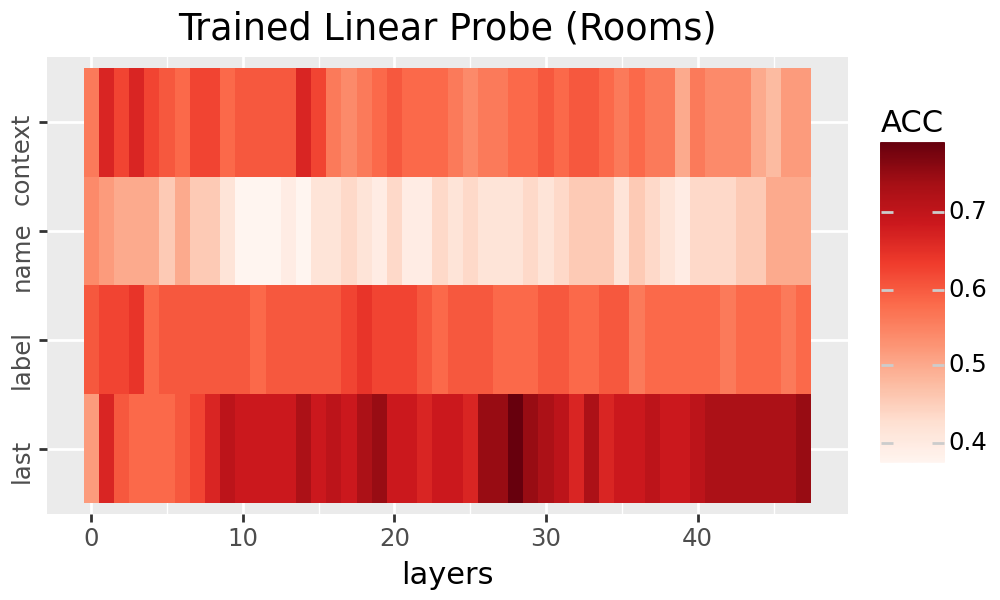

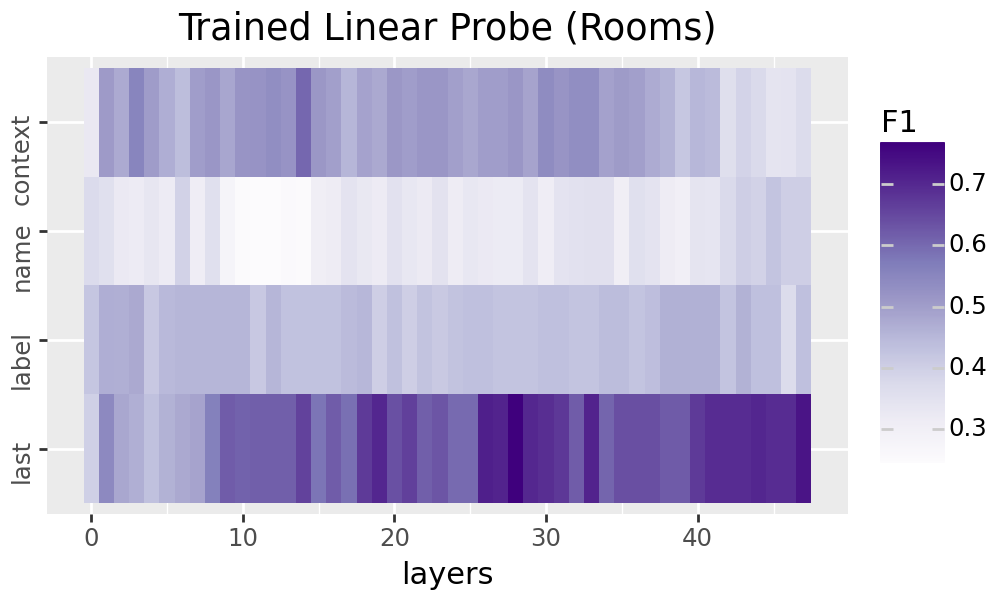

In [22]:
plot_results(rooms_stats, "Rooms")

Colors

In [ ]:
colors_context_markers = ['is']
colors_trainset = generate_doable_examples(colors['train'], model, tokenizer, color_label_mapping.keys(), colors_context_markers) + generate_doable_examples(colors['validation'], model, tokenizer, color_label_mapping.keys(), colors_context_markers)
colors_evalset = generate_doable_examples(colors['test'], model, tokenizer, color_label_mapping.keys(), colors_context_markers)

In [ ]:
colors_stats = train_eval_probe(model, tokenizer, colors_trainset, colors_evalset, color_label_mapping)

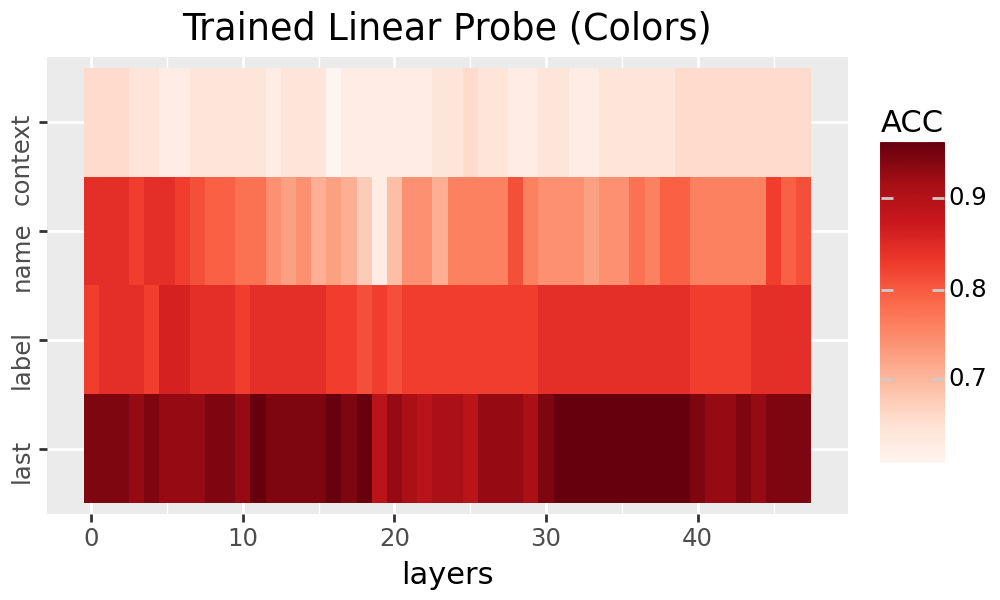

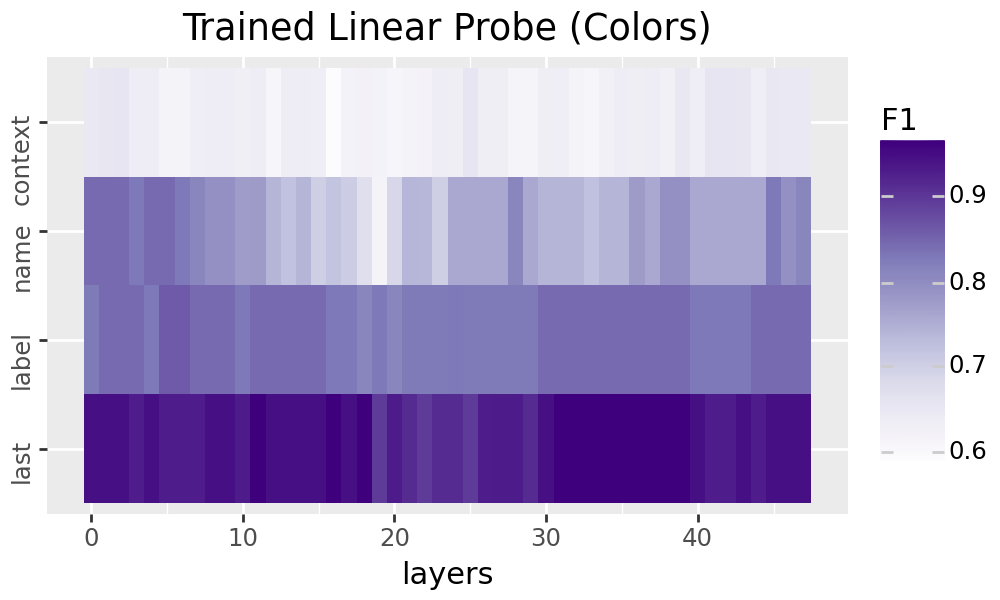

In [18]:
plot_results(colors_stats, "Colors")